In [70]:
# Import statements and set up auth header
import requests
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from config import foursquare_key
auth_header = {"Authorization": foursquare_key}

In [53]:
# Test FourSquare API: Request autocomplete for search query and grab first result
query = "Ontario Tech University"
request = requests.get("https://api.foursquare.com/v3/autocomplete", params={'query': query}, headers=auth_header)
result = request.json()
# Output result to jupyter
result

{'results': [{'type': 'address',
   'text': {'primary': 'A-174 University Ave',
    'secondary': 'Kingston, ON, K7L 3P4',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a2b8b',
   'address': {'address_id': 'CA-435041340000000a2b8b'}},
  {'type': 'address',
   'text': {'primary': 'A-300 University Ave',
    'secondary': 'Kingston, ON, K7L 3R2',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a364e',
   'address': {'address_id': 'CA-435041340000000a364e'}},
  {'type': 'address',
   'text': {'primary': 'A-201 University Ave',
    'secondary': 'Kingston, ON, K7L 3P7',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a1a17',
   'address': {'address_id': 'CA-435041340000000a1a17'}},
  {'type': 'address',
   'text': {'primary': 'A-260 University Ave',
    'secondary': 'Kingston, ON, K7L 3P

In [54]:
# Return place for first result
place_link = result['results'][0]['link']
request_next = requests.get("https://api.foursquare.com" + place_link, headers=auth_header)
result_next = request_next.json()
# Output place address
result_next['location']['formatted_address']

KeyError: 'formatted_address'

In [ ]:
#Draw initial folium map using Toronto Police GeoJSON
m = folium.Map(location = [43.6532, - 79.3832], zoom_start=10)

toronto_neighbourhood_edge = f"data/TorontoNeighbourhoodCrimeRatesBoundaryFile.geojson"

folium.GeoJson(toronto_neighbourhood_edge, name="torontoEdge").add_to(m)

m

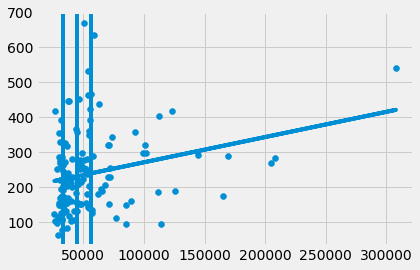

In [143]:
#Read csv into pandas dataframe
df = pd.read_csv("data/BnE_Income.csv")
#Undecided if we wanna keep outliers or not, uncomment next line to remove them
#df = df[(np.abs(stats.zscore(df['Total income: Average amount ($)']))<3)]
x = df['Total income: Average amount ($)']
y = df['BreakandEnter_Rate_2016']
#Create line of best fit from Average income vs. BnE Rate
a, b = np.polyfit(x, y, 1)
#Draw scatter plot and plot line of best fit (just for our own visualization atm)
plt.scatter(x, y)
plt.plot(x, a*x+b)

#Drawing quartiles onto the plot
plt.axvline(np.quantile(x, 0.25))
plt.axvline(np.quantile(x, 0.5))
plt.axvline(np.quantile(x, 0.75))

[[ 57436.72727273    277.45909091]
 [103398.5           247.29166667]
 [159630.66666667    251.43333333]
 [ 35480.32051282    210.07435897]]


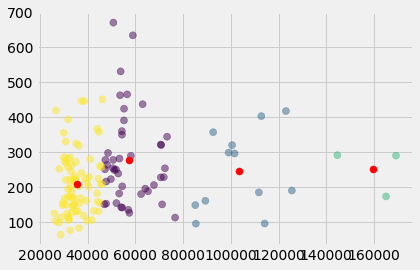

In [141]:
#testing clustering
#https://datatofish.com/k-means-clustering-python/ site i followed for clustering logic
k_df = pd.concat([df['Total income: Average amount ($)'],df['BreakandEnter_Rate_2016']], axis=1, keys=['x', 'y'])

kmeans = KMeans(n_clusters=4).fit(k_df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(k_df['x'], k_df['y'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1,], c='red', s=50)
plt.show()
